# Taarifa Data Set. Problem Understanding

The point of this project is to predict which pumps that help to clean and maintain water well's throughout Tanzania are to be fixed before they are broken. My immediate response to this problem is to look at the data, see what is missing, what is present. My next step is to look at domain knowledge. I am specifically going to look at the types of water pumps used in these wells. I feel that it is important to see if there have been any recalls on any of the models used. After cleaning the datasets I will create a baseline model using Gaussian Naive Bayes. From here I will tune by using hyper parameter optimisation. I feel that the second model I will use will be stacking. 

There are two methods of looking at the data. One through downloading the API and it's appropriate software. The second are the csv files that are given on the competition website with Data Camp. 
I have decided to go through the second route. I have attempted to download the API but have run into some problems which I will later explore but cannot do so given the time frame. 

I have not conducted a ternary classification, which is what we are dealing with here in the Taarifa dataset. 

# Data Understanding
https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

# Data Cleaning

This notebook contains the data cleaning phase of the project. The raw datasets have been downloaded from the Driven Data website. The datasets are as follows:

"test_set_values.csv": the competition testing set, containing only the id and the target variable ("status_group")

"training_set_labels.csv": the competition training set, containing the target variable

"training_set_values.csv": the competition training set, containing all the features

## Step 1
### Initial Setup

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [4]:
# loading datasets into DataFrames
df_inspect = pd.read_csv('/Users/aqureshi/Desktop/DS_021720/mod3_project/test_set_values.csv')
df2_inspect = pd.read_csv('/Users/aqureshi/Desktop/DS_021720/mod3_project/training_set_labels.csv')
df3_inspect = pd.read_csv('/Users/aqureshi/Desktop/DS_021720/mod3_project/training_set_values.csv')

The testing data set will be ignored for now, as it relates to the competition. The competition training data will be combined into a single DF for cleaning purposes, and will itself be split into testing/training/validation sets further down the line.

In [5]:
# Combining competition training sets
df4_combo = df3_inspect.join(df2_inspect, rsuffix='_r')
df5_combo = df4_combo.drop(['id_r'], axis=1)

## Step 2
### Data Exploration

The features included in the dataset are described as follows (as per the Driven Date website):

- **amount_tsh** - Total static head (amount water available to waterpoint)
- **date_recorded** - The date the row was entered
- **funder** - Who funded the well
- **gps_height** - Altitude of the well
- **installer** - Organization that installed the well
- **longitude** - GPS coordinate
- **latitude** - GPS coordinate
- **wpt_name** - Name of the waterpoint if there is one
- **num_private** -
- **basin** - Geographic water basin
- **subvillage** - Geographic location
- **region** - Geographic location
- **region_code** - Geographic location (coded)
- **district_code** - Geographic location (coded)
- **lga** - Geographic location
- **ward** - Geographic location
- **population** - Population around the well
- **public_meeting** - True/False
- **recorded_by** - Group entering this row of data
- **scheme_management** - Who operates the waterpoint
- **scheme_name** - Who operates the waterpoint
- **permit** - If the waterpoint is permitted
- **construction_year** - Year the waterpoint was constructed
- **extraction_type** - The kind of extraction the waterpoint uses
- **extraction_type_group** - The kind of extraction the waterpoint uses
- **extraction_type_class** - The kind of extraction the waterpoint uses
- **management** - How the waterpoint is managed
- **management_group** - How the waterpoint is managed
- **payment** - What the water costs
- **payment_type** - What the water costs
- **water_quality** - The quality of the water
- **quality_group** - The quality of the water
- **quantity** - The quantity of water
- **quantity_group** - The quantity of water
- **source** - The source of the water
- **source_type** - The source of the water
- **source_class** - The source of the water
- **waterpoint_type** - The kind of waterpoint
- **waterpoint_type_group** - The kind of waterpoint

The features were inspected one by one to determine if any need to be edited or removed. Below are the features for which an issue has been identified:

- **date_recorded**: deemed irrelevant for analysis - *to remove*
- **funder**: missing values - *to fill*
- **installer**: missing values - *to fill*
- **wpt_name**: deemed irrelevant for analysis - *to remove*
- **num_private**: empty feature - *to remove*
- **subvillage**: deemed irrelevant for analysis - *to remove*
- **region**: deemed irrelevant for analysis - *to remove*
- **region_code**: deemed irrelevant for analysis - *to remove*
- **district_code**: deemed irrelevant for analysis - *to remove*
- **lga**: deemed irrelevant for analysis - *to remove*
- **ward**: deemed irrelevant for analysis - *to remove*
- **public_meeting**: deemed irrelevant for analysis - *to remove*
- **recorded_by**: all values are the same, none missing - *to remove*
- **scheme_management**: missing values, duplicate of 'management' - *to remove*
- **scheme_name**: missing values, deemed irrelevant for analysis - *to remove*
- **permit**: missing values - *to fill*
- **construction_year**: mostly zero; not useful for analyis - *to convert to age in months and fill missing with median*
- **extraction_type_group** - subsumed by 'extraction_type' - *to remove*
- **extraction_type_class** - subsumed by 'extraction_type' - *to remove*
- **payment_type**: duplicate of 'payment' - *to remove*
- **water_quality**: subsumed by 'quality_group' - *to remove*
- **quantity_group**: duplicate of 'quantity' - *to remove*
- **source_type**: subsumed by 'source' - *to remove*
- **source_class**: subsumed by 'source' - *to remove*
- **waterpoint_type_group**: subsumed by 'waterpoint_type' - *to remove*

## Step 3
### Processing

A function is created in order to clean the entire dataset. The function is documented below, and can also be used to clean the competition test set, if required.

In [6]:
# creating function to clean and rearrange dataframe

def preprocess_clean(dataframe, cols_to_drop, cols_to_fill, col_order, target_name):
    
    """Function to clean and rearrange dataframe for use in the model.
    
    The function will take the dataframe as an argument and perform the following operations:
    - Fill 'construction year' nil values with median non-zero value
    - Convert 'construction year' to age in years
    - Remove the rows identified as irrelevant
    - Fill categorical variable NAs with 'unknown'
    - Rearranges column order for readibility
    
    Args:
        'dataframe': the dataframe to clean
        'cols_to_drop': list of columns to drop from the dataframe
        'cols_to_fill': list of categorical columns to fill
        'col_order': list of columns in the desired order for the output
        'target_name': name (as string) of target variable
    
    Returns:
        A cleaned dataframe with the desired columns in the order specified
    """
    
    # creating copy of dataframe
    df = dataframe.copy()
    
    # converting 'construction_year' to age in years and filling zeros with median
    if 'construction_year' in df.columns:
        df.replace(0, np.nan, inplace=True)
        median_x = df['construction_year'].median(skipna=True)
        df['construction_year'].fillna(median_x, inplace=True)
        df['age_years'] = round(2019 - df['construction_year'],0)

    else:
        pass
    
     # dropping columns identified above as irrelvant
    df2 = df.drop(cols_to_drop, axis=1)
    
    # filling missing values with 'unknown' categorical
    df2[cols_to_fill] = df2[cols_to_fill].fillna(value='unknown')
    
    # rearranging column order, and excluding target variable if not in dataframe
    if target_name in df2.columns:
        df3 = df2[col_order]
    else:
        list2 = order_cols[:order_cols.index(target_name)]+order_cols[order_cols.index(target_name)+1:]
        df3 = df2[list2]
    
    df4 = df3.fillna(0)
    
    return df4
    

In [7]:
# creating list of columns to drop, in order to pass into the cleaning function
drop_cols = ['date_recorded',
                'wpt_name',
                'num_private',
                'subvillage',
                'region',
                'region_code',
                'district_code',
                'lga',
                'ward',
                'public_meeting',
                'recorded_by',
                'scheme_management',
                'scheme_name',
                'construction_year',
                'extraction_type_group',
                'extraction_type_class',
                'payment_type',
                'water_quality',
                'quantity_group',
                'source_type',
                'source_class',
                'waterpoint_type_group']

# creating list of columns to fill with 'unknown'
fill_cols = ['funder',
            'installer',
            'permit']

# creating list of columns order
order_cols = ['id',
            'amount_tsh',
            'funder',
            'installer',
            'gps_height',
            'longitude',
            'latitude',
            'basin',
            'population',
            'permit',
            'extraction_type',
            'management',
            'management_group',
            'payment',
            'quality_group',
            'quantity',
            'source',
            'waterpoint_type',
            'age_years',
            'status_group',]

In [8]:
# cleaning the datatset using the cleaning function
df_clean = preprocess_clean(df5_combo, drop_cols, fill_cols, order_cols, 'status_group')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
id                  59400 non-null float64
amount_tsh          59400 non-null float64
funder              59400 non-null object
installer           59400 non-null object
gps_height          59400 non-null float64
longitude           59400 non-null float64
latitude            59400 non-null float64
basin               59400 non-null object
population          59400 non-null float64
permit              59400 non-null object
extraction_type     59400 non-null object
management          59400 non-null object
management_group    59400 non-null object
payment             59400 non-null object
quality_group       59400 non-null object
quantity            59400 non-null object
source              59400 non-null object
waterpoint_type     59400 non-null object
age_years           59400 non-null float64
status_group        59400 non-null object
dtypes: float64(7), object(13)
memory usage:

In [9]:
df_clean.to_csv('df_clean.csv')

In [10]:
data = pd.read_csv('df_clean.csv')

In [11]:
data.head()

,Unnamed: 0,id,amount_tsh,funder,installer,gps_height,longitude,latitude,basin,population,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,waterpoint_type,age_years,status_group
0,0,69572.0,6000.0,Roman,Roman,1390.0,34.938093,-9.856322,Lake Nyasa,109.0,unknown,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,20.0,functional
1,1,8776.0,0.0,Grumeti,GRUMETI,1399.0,34.698766,-2.147466,Lake Victoria,280.0,True,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,9.0,functional
2,2,34310.0,25.0,Lottery Club,World vision,686.0,37.460664,-3.821329,Pangani,250.0,True,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,10.0,functional
3,3,67743.0,0.0,Unicef,UNICEF,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,33.0,non functional
4,4,19728.0,0.0,Action In A,Artisan,0.0,31.130847,-1.825359,Lake Victoria,0.0,True,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,19.0,functional


In [54]:
data.status_group.value_counts() #This shows us the ternary clasiffication we are focusing on. 


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Just over half of all the waterwells in Tanzania are functional according to this data. 

In [59]:
#Train test split

In [60]:
from sklearn.model_selection import train_test_split
y = data['status_group']
X = data.drop(columns='status_group', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10) #x y train test split for train
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train,y_train,test_size=.2, random_state=123)

In [65]:
X_train.shape

(44550, 21)

In [66]:
from sklearn.tree import DecisionTreeClassifier
baseline = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=1)


In [68]:
baseline.fit(X_train, y_train)
#must turn into floats, from here should I 

ValueError: could not convert string to float: 'Dhv'

## Create a map of the wells. This is helpful with the overall problem. Here we will look at where they are located, the main sources of water for the wells. This will give a general analysis and assumption of the bigger picture. This will not become clear until after we do ternary classification. 

In [21]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [22]:
import descartes
from descartes.patch import PolygonPatch

In [23]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline 

In [24]:
street_map = gpd.read_file('/Users/aqureshi/Desktop/DS_021720/mod3_project/Tanzania_mod3/data/TAN_admin_SHP')

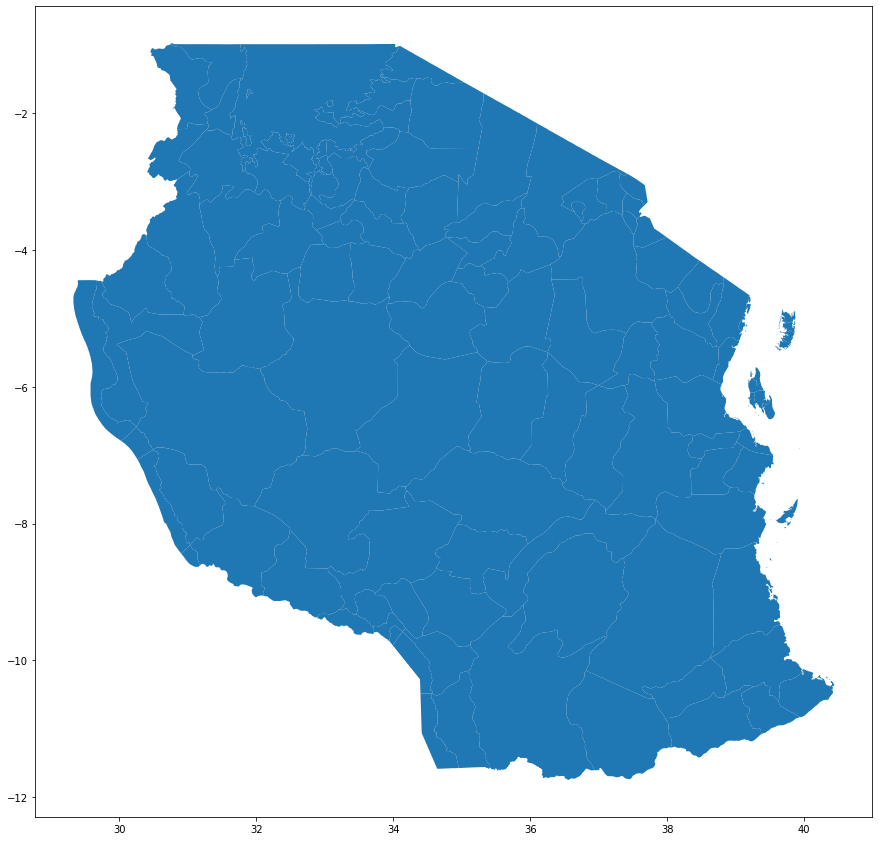

In [25]:
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)


In [27]:
crs = {'init': 'espg:4326'}
data.head()

,Unnamed: 0,id,amount_tsh,funder,installer,gps_height,longitude,latitude,basin,population,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,waterpoint_type,age_years,status_group
0,0,69572.0,6000.0,Roman,Roman,1390.0,34.938093,-9.856322,Lake Nyasa,109.0,unknown,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,20.0,functional
1,1,8776.0,0.0,Grumeti,GRUMETI,1399.0,34.698766,-2.147466,Lake Victoria,280.0,True,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,9.0,functional
2,2,34310.0,25.0,Lottery Club,World vision,686.0,37.460664,-3.821329,Pangani,250.0,True,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,10.0,functional
3,3,67743.0,0.0,Unicef,UNICEF,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,33.0,non functional
4,4,19728.0,0.0,Action In A,Artisan,0.0,31.130847,-1.825359,Lake Victoria,0.0,True,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,19.0,functional


In [29]:
geometry = [Point(xy) for xy in zip( data['longitude'], data['latitude'])]
geometry[:3]

In [47]:
geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)
geo_df.head()

,Unnamed: 0,id,amount_tsh,funder,installer,gps_height,longitude,latitude,basin,population,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,waterpoint_type,age_years,status_group,geometry
0,0,69572.0,6000.0,Roman,Roman,1390.0,34.938093,-9.856322,Lake Nyasa,109.0,unknown,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,20.0,functional,POINT (34.93809 -9.85632)
1,1,8776.0,0.0,Grumeti,GRUMETI,1399.0,34.698766,-2.147466,Lake Victoria,280.0,True,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,9.0,functional,POINT (34.69877 -2.14747)
2,2,34310.0,25.0,Lottery Club,World vision,686.0,37.460664,-3.821329,Pangani,250.0,True,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,10.0,functional,POINT (37.46066 -3.82133)
3,3,67743.0,0.0,Unicef,UNICEF,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,33.0,non functional,POINT (38.48616 -11.15530)
4,4,19728.0,0.0,Action In A,Artisan,0.0,31.130847,-1.825359,Lake Victoria,0.0,True,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,19.0,functional,POINT (31.13085 -1.82536)


/usr/local/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


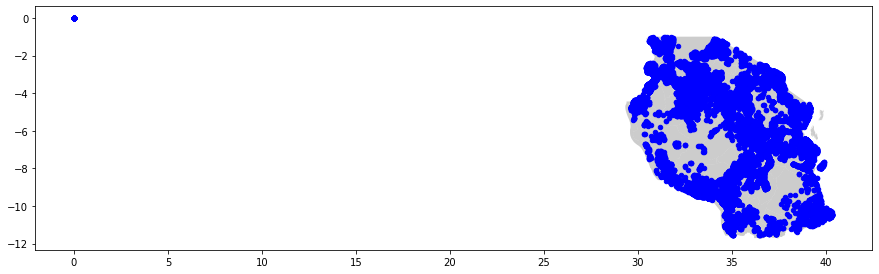

No handles with labels found to put in legend.


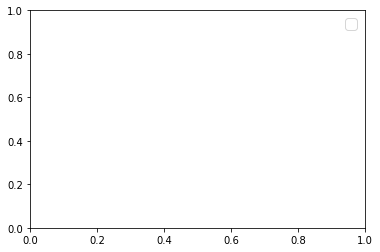

In [49]:
fig, ax = plt.subplots(1, figsize=(15,15))
street_map.plot(ax=ax, alpha=.4, color='grey')

variable = 'status_group'
geo_df[geo_df['status_group'] == 'not functional'].plot(ax=ax, markersize=20, color='red', marker='-', label='not functional')
geo_df[geo_df['status_group'] == 'functional'].plot(ax=ax, markersize=20, color='blue', marker='o', label='functional')
geo_df[geo_df['status_group'] == 'faulty'].plot(ax=ax, markersize=20, color='orange', marker='^', label='faulty')

#range of chloropleth
vmin, vmax = 120,220

# show map
plt.show()

plt.legend(prop={'size':15})

In [ ]:
#will fix this later

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

In [52]:
X = data.drop(columns='status_group', axis=1)
y = data['status_group']
logreg = LogisticRegression(C=1e5)
logreg.fit(X,y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TypeError: float() argument must be a string or a number, not 'Point'